In [1]:
import numpy as np
from scipy.linalg import expm
from ncon import ncon
from scipy.linalg import svd, norm
import Corelations
from numba import jit
import Tools
from Tools import truncate3, truncate2, truncate1
from Tools import estimated_time
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import time
import Ising
import BoseHubbard
import SVDU
import os
import NTU
import CTMRG
import CTMRG_better

plt.rcParams["figure.figsize"] = (16, 9)

I = np.array([[1, 0], [0, 1]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
X = np.array([[0, 1], [1, 0]])

[0.00000000e+00 2.16347319e-04 1.29346650e-03 3.83989712e-03
 8.41625714e-03 1.55309229e-02 2.56352476e-02 3.91183104e-02
 5.63011897e-02 7.74307584e-02 1.02672996e-01 1.32105820e-01
 1.65711441e-01 2.03368241e-01 2.44842189e-01 2.89777806e-01
 3.37688685e-01 3.87947592e-01 4.39776172e-01 4.92234272e-01]
[0.00000000e+00 8.41768150e-05 4.62795046e-04 1.32474620e-03
 2.85409788e-03 5.22398058e-03 8.58991573e-03 1.30826115e-02
 1.88002546e-02 2.58003267e-02 3.40909782e-02 4.36219895e-02
 5.42753533e-02 6.58555138e-02 7.80792949e-02 9.05655557e-02
 1.02824608e-01 1.14247431e-01 1.24094728e-01 1.31485846e-01]


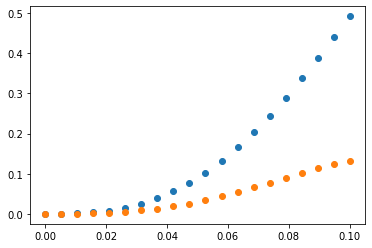

In [32]:
d=10

H1 = np.random.randn(d,d) + 1j * np.random.randn(d,d)
H2 = np.random.randn(d,d) + 1j * np.random.randn(d,d)
H1 = (H1+H1.conj().T)/2
H2 = (H2+H2.conj().T)/2
H=H1+H2
OP = np.random.randn(d,d) + 1j * np.random.randn(d,d)
OP = (OP+OP.conj().T)/2
H1H1, H2H2, HH = H1@H1, H2@H2, H@H
ket = np.random.randn(d) + 1j * np.random.randn(d)

def expm(Hx,t): return np.eye(d)+ 1j*t*Hx - t*t/2 * Hx@Hx - 1j * t*t*t/6*Hx@Hx@Hx
def U1(t): return expm(H1,t)
def U2(t): return expm(H2,t)
def U(t): return expm(H,t)

oplist0, oplist1 = [], []
dts = np.linspace(0,0.1,20)
for dt in dts:
    ket_exact = U(dt) @ ket
    ket_approx0 = U1(dt)@U2(dt)@ket
    ket_approx1 = U1(dt/2)@U2(dt/2)@U1(dt/2)@U2(dt/2)@ket
    oplist0.append(ket_exact.conj() @ OP @ ket_exact - ket_approx0.conj() @ OP @ ket_approx0)
    oplist1.append(ket_exact.conj() @ OP @ ket_exact - ket_approx1.conj() @ OP @ ket_approx1)

oplist0=np.array(oplist0).real
oplist1=np.array(oplist1).real

plt.scatter(dts,oplist0)
plt.scatter(dts,oplist1)
print(oplist0)
print(oplist1)

In [2]:
d=10
mu=0
U=1
J=1/19.6
dt=0.05*19.6
r=d*d

a = np.diag(np.sqrt(np.arange(1, d)), k=1)
ah = a.T
n = ah @ a
nn = n @ n
I = np.eye(d)

HJ = -J * (np.einsum('ij,kl->jlik', a, ah) + np.einsum('ij,kl->jlik', ah, a)) / 2
HU = U / 2 * (nn - n) - mu * n

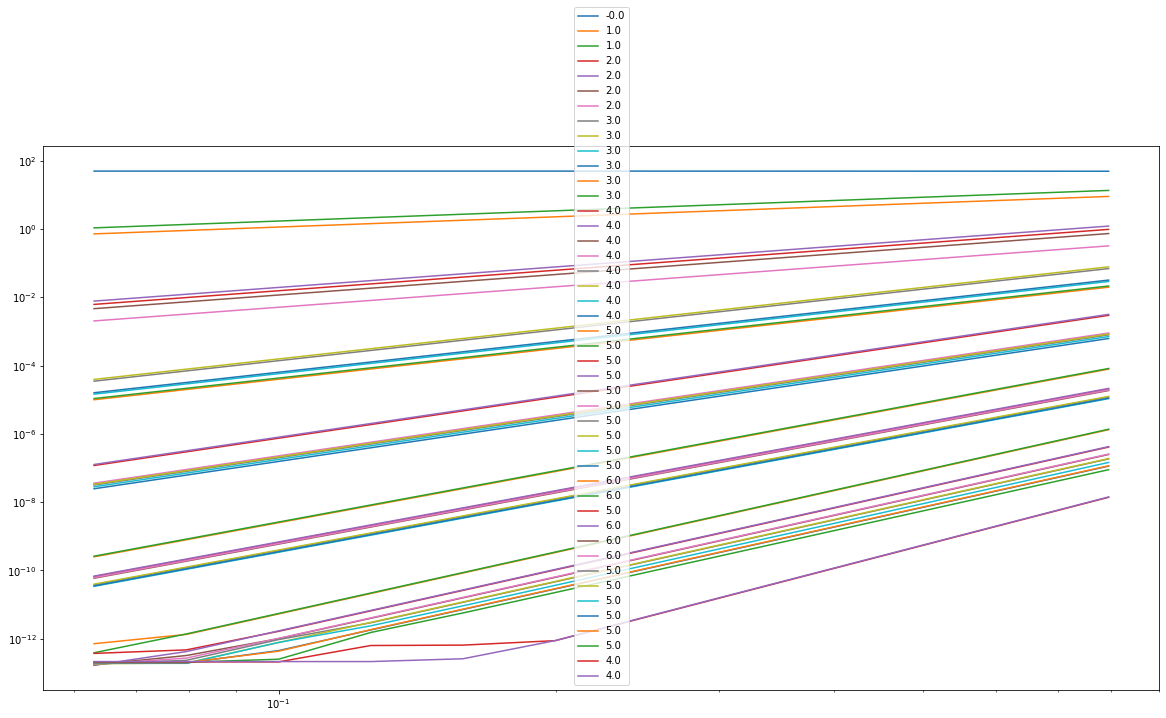

In [12]:
b=[]
dts=[]
plt.rcParams['figure.figsize']=[20,10]
for esdasd in np.arange(-1.2,0,0.3):
    dt = 10**esdasd
    _, s, _ = Tools.truncate3(
        expm(-1j * dt * HJ.reshape(d * d, d * d)).reshape(d, d, d, d).swapaxes(1, 2).reshape(d * d, d * d), r)
    b.append(s)
    dts.append(dt)

b = np.array(b).T
plt.xscale("log")
plt.yscale("log")
for i in range(45):
    plt.plot(dts,(b[i]*(i+1)*5),label=str(np.round(np.log(b[i][0]/b[i][-1])/np.log(dts[0]/dts[-1]))))
plt.legend()
plt.show()

In [18]:
d=3
r=d*d
dt=0.05*19.6
J=1/19.6
U=1
mu=0

A0 = np.zeros((r,r,r,d))
A0[0,0,0,1]=1
PEPS = BoseHubbard.TrotterGate(d,r,dt,J,U,mu)
PEPS['A'] = ncon([A0,PEPS['GA']],([-1,-3,-4,1],[1,-5,-2]))
PEPS['B'] = ncon([A0,PEPS['GB']],([-1,-2,-3,1],[1,-5,-4]))
np.savez("./onegatetest/PEPS.npz",A=PEPS['A'],B=PEPS['B'],GA=PEPS['GA'],GB=PEPS['GB'])
env = CTMRG_better.CTMRGstep(PEPS['A'],PEPS['B'],20,ifprint=True,precision=1e-13)
np.savez('./onegatetest/RHOA.npz', rhoA=env['rhoA'], rhoB=env['rhoB'], E_E_A=env['E_E_A'],
                 E_E_B=env['E_E_B'], E_W_A=env['E_W_A'], E_W_B=env['E_W_B'], E_S_A=env['E_S_A'], E_S_B=env['E_S_B'],
                 E_N_A=env['E_N_A'], E_N_B=env['E_N_B'], C_NW_A=env['C_NW_A'], C_SW_B=env['C_SW_B'],
                 C_NE_B=env['C_NE_B'], C_SE_A=env['C_SE_A'], C_NW_B=env['C_NW_B'], C_SW_A=env['C_SW_A'],
                 C_NE_A=env['C_NE_A'], C_SE_B=env['C_SE_B'], error=env['error'])

iter:  0 	 0
	##################################################
	Halves calculated
	QR done
	 [1.0043815 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
	 [1.00501006 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
	Isometries calculated
	Tensors updated
	 [[ 1.24895868e-03+0.00000000e+00j  1.21443345e-19+2.08089295e-22j
  -2.75674136e-19+2.92800718e-20j]
 [ 1.21443345e-19-2.08089295e-22j  9.97502083e-01+0.00000000e+00j
  -4.60996192e-18+8.64285961e-18j]
 [-2.75674136e-19-2.92800718e-20j -4.60996192e-18-8.64285961e-18j
   1.24895868e-03+0.00000000e+00j]]
	 [[ 1.24895868e-03+0.00000000e+00j -2.01085404e-19-1.13494053e-22j
  -2.75584943e-19+2.88744524e-20j]
 [-2.01085404e-19+1.13494053e-22j  9.97502083e-01+0.00000000e+0

In [13]:
d = 10
lndt0 = -11
a = np.diag(np.sqrt(np.arange(1, d, 1)), 1)
ah = a.T

HJ = -(np.einsum('ij,kl->jlik', a, ah) + np.einsum('ij,kl->jlik', ah, a)) / 2
u, s0, vh = svd(
    expm(-1j * np.exp(lndt0) * HJ.reshape(d * d, d * d)).reshape(d, d, d, d).swapaxes(1, 2).reshape(d * d, d * d))

slist = []
dtlist = []

for dt in np.exp(np.linspace(lndt0, 0, 100, endpoint=True)):
    u, s, vh = svd(expm(-1j * dt * HJ.reshape(d * d, d * d)).reshape(d, d, d, d).swapaxes(1, 2).reshape(d * d, d * d))
    slist.append(s / s0)
    dtlist.append(dt)

slist = np.array(slist).T
dtlist = np.array(dtlist)

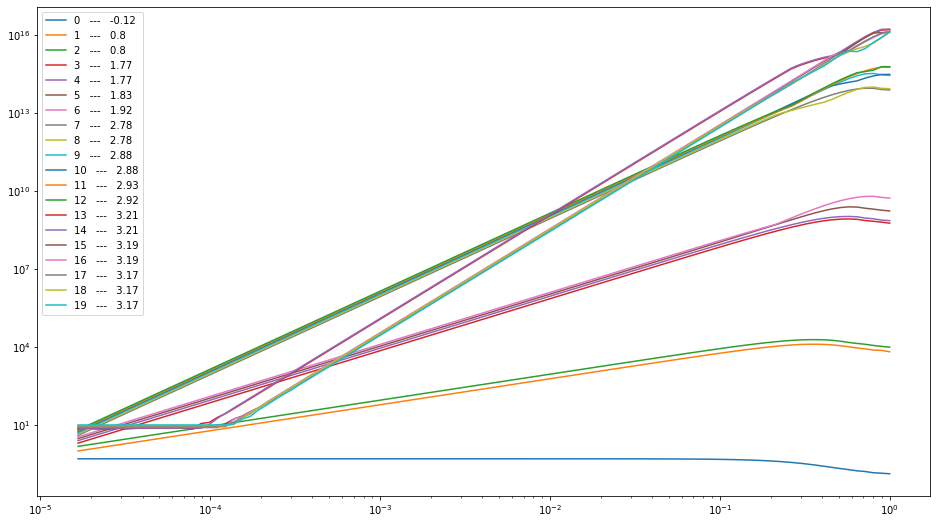

In [3]:
fig = plt.figure()
ax = plt.gca()
for i in range(20):
    ax.plot(dtlist, (i + 1) / 2 * slist[i], label=str(i) + "   ---   " + str(
        np.round(np.log(slist[i][0] / slist[i][-1]) / np.log(dtlist[0] / dtlist[-1]), 2)))
ax.set_xscale('log')
ax.legend()
ax.set_yscale('log')

In [ ]:
np.log()

00000
1.264911064067352
#######################
00001
1.2649577815054323
#######################
00002
1.2649577281435531
#######################
00003
1.264957737406294
#######################
00004
1.2649577460756987
#######################
00007
1.264957770588257
#######################
00013
1.2649578222644962
#######################
00016
1.2649578485165784
#######################
00020
1.2649578845724188
#######################
00025
1.2649579296698563
#######################
00038
1.264958040949561
#######################
00042
1.2649580768100324
#######################
00050
1.2649581483018073
#######################
00054
1.2649581836172565
#######################
00059
1.2649582268525348
#######################
00079
1.2649584030905279
#######################
00082
1.264958429914272
#######################
00090
1.2649584988651539
#######################
00097
1.2649585600416124
#######################
00098
1.2649585684867874
#######################
00113
1.264958699621185
#

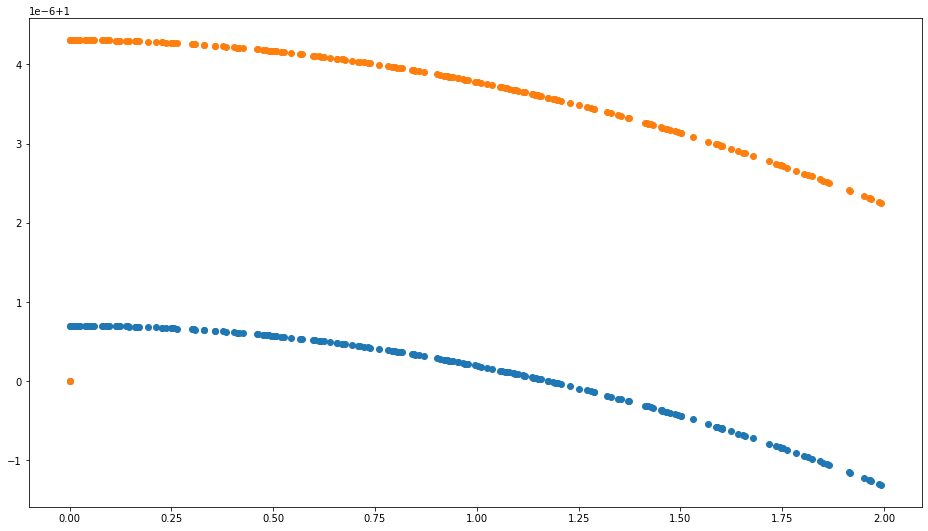

In [2]:
ctms = os.scandir(r"D:\PyCharmProjects\pythonProject1\ctm_n2")
Nlist, NNlist, ts, err = [], [], [], []

A = np.diag(np.sqrt(np.arange(1, 5)), 1)
NN = 0

for ctm in ctms:
    if ctm.name[0] == 'N': continue
    NN += 1
    print(ctm.name[5:10])
    env = dict(np.load(ctm.path))
    #print(norm(env['rhoA']-0.2*np.ones((5,5))))
    #print("#######################")
    Nlist.append(np.trace(env['rhoA'] @ A.T @ A).real)
    NNlist.append(np.trace(env['rhoA'] @ A.T @ A @ A.T @ A).real)
    ts.append(int(ctm.name[5:10]) / 1000)
    err.append(env['error'])

plt.ylim((-0.1, 1.1))
err = np.array(err) * 3000000000
plt.clf()
plt.scatter(ts, Nlist)
plt.scatter(ts, NNlist)
plt.show()

In [5]:
# d1 = 2
# d2 = 3
# D2 = 5
# D1 = 7
# D4 = 11
# D3 = 13
# chi1 = 17
# chi2 = 19
# chi3 = 23
# chi9 = 29
# chi8 = 31
# chi7 = 37
# chi6 = 41
# chi5 = 43
# chi4 = 47
# chi10 = 53
# chi11 = 59
# chi12 = 61

chi = 10
D = 5
d = 2

d1 = d
d2 = d
D2 = D
D1 = D
D4 = D
D3 = D
chi1 = chi
chi2 = chi
chi3 = chi
chi9 = chi
chi8 = chi
chi7 = chi
chi6 = chi
chi5 = chi
chi4 = chi
chi10 = chi
chi11 = chi
chi12 = chi

# A = np.random.randn(D,D,D,D,d)
# B = np.random.randn(D,D,D,D,d)
# I = np.eye(d)
# OP = I
# E_E_A = np.random.randn(chi,chi,D,D)
# E_E_B = np.random.randn(chi,chi,D,D)
# E_W_A = np.random.randn(chi,chi,D,D)
# E_W_B = np.random.randn(chi,chi,D,D)
# E_S_A = np.random.randn(chi,chi,D,D)
# E_S_B = np.random.randn(chi,chi,D,D)
# E_N_A = np.random.randn(chi,chi,D,D)
# E_N_B = np.random.randn(chi,chi,D,D)
# C_NW_A = np.random.randn(chi,chi)
# C_NE_B = np.random.randn(chi,chi)
# C_SE_A = np.random.randn(chi,chi)
# C_SW_B = np.random.randn(chi,chi)

A = np.random.randn(D4, D1, D3, D2, d1)
B = np.random.randn(D3, D2, D4, D1, d2)
I1 = np.eye(d1)
I2 = np.eye(d2)
OP1 = I1
OP2 = I2
E_E_A = np.random.randn(chi5, chi4, D1, D1)
E_E_B = np.random.randn(chi6, chi5, D2, D2)
E_W_A = np.random.randn(chi11, chi10, D1, D1)
E_W_B = np.random.randn(chi12, chi11, D2, D2)
E_S_A = np.random.randn(chi9, chi8, D4, D4)
E_S_B = np.random.randn(chi8, chi7, D3, D3)
E_N_A = np.random.randn(chi3, chi2, D3, D3)
E_N_B = np.random.randn(chi2, chi1, D4, D4)
C_NW_A = np.random.randn(chi1, chi12)
C_NE_B = np.random.randn(chi4, chi3)
C_SE_A = np.random.randn(chi7, chi6)
C_SW_B = np.random.randn(chi10, chi9)


def AddLayerEMPTY(Left):
    Left1 = ncon([Left, E_N_B], ([1, -4, -5, -6, -7, -8], [-1, 1, -2, -3]))

    Left1 = Left1.swapaxes(1, 2).reshape(chi2, D4, D4 * D2, D2, D1, D1, chi9)
    Ap = A.swapaxes(3, 2).swapaxes(2, 1).reshape(D4 * D2, D1, D3, d1)
    Left2 = ncon([Left1, Ap], ([-1, -5, 1, -6, -7, -8, -9], [1, -2, -3, -4]))

    Left2 = Left2.reshape(chi2, D1, D3, d1 * D2 * D4, D1, D1, chi9)
    Ap = A.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d1 * D2 * D4,
        D1, D3).conj()
    Left3 = ncon([Left2, Ap], ([-1, -2, -4, 1, -6, -7, -8], [1, -3, -5]))

    Ap = B.swapaxes(3, 2).swapaxes(2, 1).reshape(D3 * D1, D2, D4, d2)
    Left3 = Left3.swapaxes(3, 4).reshape(chi2, D1, D1, D3, D3 * D1, D1, chi9)
    Left4 = ncon([Left3, Ap], ([-1, -2, -3, -7, 1, -8, -9], [1, -4, -5, -6]))

    Ap = B.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d2 * D1 * D3,
        D2, D4).conj()
    Left4 = Left4.reshape(chi2, D1, D1, D2, D4, d2 * D3 * D1, chi9)
    Left5 = ncon([Left4, Ap], ([-1, -2, -3, -4, -6, 1, -8], [1, -5, -7]))

    E_S_Ap = E_S_A.swapaxes(0, 1).reshape(chi8, chi9 * D4 * D4)
    Left5 = Left5.reshape(chi2, D1, D1, D2, D2, D4 * D4 * chi9)
    Left6 = ncon([Left5, E_S_Ap], ([-1, -2, -3, -4, -5, 1], [-6, 1]))

    ###############################################

    Left7 = ncon([Left6, E_N_A], ([1, -4, -5, -6, -7, -8], [-1, 1, -2, -3]))

    Left7 = Left7.swapaxes(1, 2).reshape(chi3, D3, D3 * D1, D1, D2, D2, chi8)
    Ap = B.swapaxes(3, 2).swapaxes(2, 1).reshape(D3 * D1, D2, D4, d2)
    Left8 = ncon([Left7, Ap], ([-1, -5, 1, -6, -7, -8, -9], [1, -2, -3, -4]))

    Left8 = Left8.reshape(chi3, D2, D4, d2 * D3 * D1, D2, D2, chi8)
    Ap = B.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d2 * D3 * D1,
        D2, D4).conj()
    Left9 = ncon([Left8, Ap], ([-1, -2, -4, 1, -6, -7, -8], [1, -3, -5]))

    Left9 = Left9.swapaxes(3, 4).reshape(chi3, D2, D2, D4, D2 * D4, D2, chi8)
    Ap = A.swapaxes(3, 2).swapaxes(2, 1).reshape(D2 * D4, D1, D3, d1)
    Left10 = ncon([Left9, Ap], ([-1, -2, -3, -7, 1, -8, -9], [1, -4, -5, -6]))

    Ap = A.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d1 * D2 * D4,
        D1, D3).conj()
    Left10 = Left10.reshape(chi3, D2, D2, D1, D3, d1 * D2 * D4, chi8)
    Left11 = ncon([Left10, Ap], ([-1, -2, -3, -4, -6, 1, -8], [1, -5, -7]))

    E_S_Bp = E_S_B.swapaxes(0, 1).reshape(chi7, chi8 * D3 * D3)
    Left11 = Left11.reshape(chi3, D2, D2, D1, D1, D3 * D3 * chi8)
    Left12 = ncon([Left11, E_S_Bp], ([-1, -2, -3, -4, -5, 1], [-6, 1]))

    return Left12


def AddLayerOP_Right(Left, OP):
    Left1 = ncon([Left, E_N_B], ([1, -4, -5, -6, -7, -8], [-1, 1, -2, -3]))

    Left1 = Left1.swapaxes(1, 2).reshape(chi2, D4, D4 * D2, D2, D1, D1, chi9)
    Ap = A.swapaxes(3, 2).swapaxes(2, 1).reshape(D4 * D2, D1, D3, d1)
    Left2 = ncon([Left1, Ap], ([-1, -5, 1, -6, -7, -8, -9], [1, -2, -3, -4]))

    Left2 = Left2.reshape(chi2, D1, D3, d1 * D2 * D4, D1, D1, chi9)
    Ap = A.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d1 * D2 * D4,
        D1, D3).conj()
    Left3 = ncon([Left2, Ap], ([-1, -2, -4, 1, -6, -7, -8], [1, -3, -5]))

    Ap = B.swapaxes(3, 2).swapaxes(2, 1).reshape(D3 * D1, D2, D4, d2)
    Left3 = Left3.swapaxes(3, 4).reshape(chi2, D1, D1, D3, D3 * D1, D1, chi9)
    Left4 = ncon([Left3, Ap], ([-1, -2, -3, -7, 1, -8, -9], [1, -4, -5, -6]))

    Ap = B.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d2 * D1 * D3,
        D2, D4).conj()
    Left4 = Left4.reshape(chi2, D1, D1, D2, D4, d2 * D3 * D1, chi9)
    Left5 = ncon([Left4, Ap], ([-1, -2, -3, -4, -6, 1, -8], [1, -5, -7]))

    E_S_Ap = E_S_A.swapaxes(0, 1).reshape(chi8, chi9 * D4 * D4)
    Left5 = Left5.reshape(chi2, D1, D1, D2, D2, D4 * D4 * chi9)
    Left6 = ncon([Left5, E_S_Ap], ([-1, -2, -3, -4, -5, 1], [-6, 1]))

    ###############################################

    Left7 = ncon([Left6, E_N_A], ([1, -4, -5, -6, -7, -8], [-1, 1, -2, -3]))

    Left7 = Left7.swapaxes(1, 2).reshape(chi3, D3, D3 * D1, D1, D2, D2, chi8)
    Ap = B.swapaxes(3, 2).swapaxes(2, 1).reshape(D3 * D1, D2, D4, d2)
    Left8 = ncon([Left7, Ap, OP], ([-1, -5, 2, -6, -7, -8, -9], [2, -2, -3, 1], [-4, 1]))

    Left8 = Left8.reshape(chi3, D2, D4, d2 * D3 * D1, D2, D2, chi8)
    Ap = B.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d2 * D3 * D1,
        D2, D4).conj()
    Left9 = ncon([Left8, Ap], ([-1, -2, -4, 1, -6, -7, -8], [1, -3, -5]))

    Left9 = Left9.swapaxes(3, 4).reshape(chi3, D2, D2, D4, D2 * D4, D2, chi8)
    Ap = A.swapaxes(3, 2).swapaxes(2, 1).reshape(D2 * D4, D1, D3, d1)
    Left10 = ncon([Left9, Ap], ([-1, -2, -3, -7, 1, -8, -9], [1, -4, -5, -6]))

    Ap = A.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d1 * D2 * D4,
        D1, D3).conj()
    Left10 = Left10.reshape(chi3, D2, D2, D1, D3, d1 * D2 * D4, chi8)
    Left11 = ncon([Left10, Ap], ([-1, -2, -3, -4, -6, 1, -8], [1, -5, -7]))

    E_S_Bp = E_S_B.swapaxes(0, 1).reshape(chi7, chi8 * D3 * D3)
    Left11 = Left11.reshape(chi3, D2, D2, D1, D1, D3 * D3 * chi8)
    Left12 = ncon([Left11, E_S_Bp], ([-1, -2, -3, -4, -5, 1], [-6, 1]))

    return Left12


def AddLayerOP_Left(Left, OP):
    Left1 = ncon([Left, E_N_B], ([1, -4, -5, -6, -7, -8], [-1, 1, -2, -3]))

    Left1 = Left1.swapaxes(1, 2).reshape(chi2, D4, D4 * D2, D2, D1, D1, chi9)
    Ap = A.swapaxes(3, 2).swapaxes(2, 1).reshape(D4 * D2, D1, D3, d1)
    Left2 = ncon([Left1, Ap, OP], ([-1, -5, 1, -6, -7, -8, -9], [1, -2, -3, 2], [2, -4]))

    Left2 = Left2.reshape(chi2, D1, D3, d1 * D2 * D4, D1, D1, chi9)
    Ap = A.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d1 * D2 * D4,
        D1, D3).conj()
    Left3 = ncon([Left2, Ap], ([-1, -2, -4, 1, -6, -7, -8], [1, -3, -5]))

    Ap = B.swapaxes(3, 2).swapaxes(2, 1).reshape(D3 * D1, D2, D4, d2)
    Left3 = Left3.swapaxes(3, 4).reshape(chi2, D1, D1, D3, D3 * D1, D1, chi9)
    Left4 = ncon([Left3, Ap], ([-1, -2, -3, -7, 1, -8, -9], [1, -4, -5, -6]))

    Ap = B.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d2 * D1 * D3,
        D2, D4).conj()
    Left4 = Left4.reshape(chi2, D1, D1, D2, D4, d2 * D3 * D1, chi9)
    Left5 = ncon([Left4, Ap], ([-1, -2, -3, -4, -6, 1, -8], [1, -5, -7]))

    E_S_Ap = E_S_A.swapaxes(0, 1).reshape(chi8, chi9 * D4 * D4)
    Left5 = Left5.reshape(chi2, D1, D1, D2, D2, D4 * D4 * chi9)
    Left6 = ncon([Left5, E_S_Ap], ([-1, -2, -3, -4, -5, 1], [-6, 1]))

    ###############################################

    Left7 = ncon([Left6, E_N_A], ([1, -4, -5, -6, -7, -8], [-1, 1, -2, -3]))

    Left7 = Left7.swapaxes(1, 2).reshape(chi3, D3, D3 * D1, D1, D2, D2, chi8)
    Ap = B.swapaxes(3, 2).swapaxes(2, 1).reshape(D3 * D1, D2, D4, d2)
    Left8 = ncon([Left7, Ap], ([-1, -5, 1, -6, -7, -8, -9], [1, -2, -3, -4]))

    Left8 = Left8.reshape(chi3, D2, D4, d2 * D3 * D1, D2, D2, chi8)
    Ap = B.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d2 * D3 * D1,
        D2, D4).conj()
    Left9 = ncon([Left8, Ap], ([-1, -2, -4, 1, -6, -7, -8], [1, -3, -5]))

    Left9 = Left9.swapaxes(3, 4).reshape(chi3, D2, D2, D4, D2 * D4, D2, chi8)
    Ap = A.swapaxes(3, 2).swapaxes(2, 1).reshape(D2 * D4, D1, D3, d1)
    Left10 = ncon([Left9, Ap], ([-1, -2, -3, -7, 1, -8, -9], [1, -4, -5, -6]))

    Ap = A.swapaxes(4, 3).swapaxes(3, 2).swapaxes(2, 1).swapaxes(1, 0).swapaxes(4, 3).swapaxes(3, 2).reshape(
        d1 * D2 * D4,
        D1, D3).conj()
    Left10 = Left10.reshape(chi3, D2, D2, D1, D3, d1 * D2 * D4, chi8)
    Left11 = ncon([Left10, Ap], ([-1, -2, -3, -4, -6, 1, -8], [1, -5, -7]))

    E_S_Bp = E_S_B.swapaxes(0, 1).reshape(chi7, chi8 * D3 * D3)
    Left11 = Left11.reshape(chi3, D2, D2, D1, D1, D3 * D3 * chi8)
    Left12 = ncon([Left11, E_S_Bp], ([-1, -2, -3, -4, -5, 1], [-6, 1]))

    return Left12


def AddRight(Left):
    C1 = ncon([C_NE_B, E_E_A], ([1, -1], [-4, 1, -2, -3]))
    C2 = ncon([C_SE_A, E_E_B], ([-1, 1], [1, -4, -2, -3]))

    C1p = C1.reshape(C1.shape[0] * C1.shape[1] * C1.shape[2], C1.shape[3])
    C2p = C2.reshape(C2.shape[0] * C2.shape[1] * C2.shape[2], C2.shape[3])
    Leftp = Left.reshape(Left.shape[0] * Left.shape[1] * Left.shape[2], Left.shape[3] * Left.shape[4] * Left.shape[5])

    T1 = ncon([Leftp, C1p, C2p], ([1, 2], [1, 3], [2, 3]))
    return T1


def __AddLeftOps(Left):
    tensors = [A, E_N_B, E_N_A, E_S_B, E_S_A, A.conj(), B, B.conj(), B, B.conj(), A, A.conj(), Left, OP1, I2]
    connects = [[14, 5, 6, 23, 28], [1, 22, 14, 15], [-1, 1, 13, 16], [2, -6, 20, 19], [21, 2, 17, 18],
                [15, 10, 11, 24, 3], [13, -2, 8, 5, 27], [16, -3, 9, 10, 4], [6, 7, 17, 25, 29],
                [11, 12, 18, 26, 29], [8, -4, 20, 7, 30], [9, -5, 19, 12, 30], [22, 23, 24, 25, 26, 21], [28, 3],
                [27, 4]]
    con_order = [14, 13, 20, 17, 3, 4, 16, 27, 11, 19, 30, 21, 25, 18, 29, 24, 26, 6, 23, 28, 22, 15, 5, 1, 10, 2,
                 7, 12, 8, 9]
    return ncon(tensors, connects, con_order)

In [12]:
corNS = np.load("./FULL/CORR_AHA_NS_00001.npz")
print(corNS['corA'])
print(corNS['corB'])
corWE = np.load("./FULL/CORR_AHA_WE_00001.npz")
print(corWE['corA'])
print(corWE['corB'])

[9.99998885e-01+0.00000000e+00j 9.43768675e-21+1.27274162e-21j
 9.43768675e-21+1.27274162e-21j 9.43768675e-21+1.27274162e-21j
 9.43768675e-21+1.27274162e-21j 9.43768675e-21+1.27274162e-21j
 9.43768675e-21+1.27274162e-21j 9.43768675e-21+1.27274162e-21j
 9.43768675e-21+1.27274162e-21j 9.43768675e-21+1.27274162e-21j
 9.43768675e-21+1.27274162e-21j 9.43768675e-21+1.27274162e-21j]
[1.00000796e+00+0.00000000e+00j 1.87451000e-30+3.16419601e-34j
 1.87451000e-30+3.16419601e-34j 1.87451000e-30+3.16419601e-34j
 1.87451000e-30+3.16419601e-34j 1.87451000e-30+3.16419601e-34j
 1.87451000e-30+3.16419601e-34j 1.87451000e-30+3.16419601e-34j
 1.87451000e-30+3.16419601e-34j 1.87451000e-30+3.16419601e-34j
 1.87451000e-30+3.16419601e-34j 1.87451000e-30+3.16419601e-34j]
[ 9.99998885e-01+0.00000000e+00j -7.73787430e-03-3.50754408e-02j
  1.31497514e-04-3.55963600e-04j -9.08126024e-06+2.62944415e-07j
  9.96358349e-12-2.69763144e-11j -7.82389467e-13+2.27379321e-14j
  5.44976644e-19-1.47567382e-18j -4.57609059e-2

In [ ]:
BPEPS = np.load("./PEPS_00000.npz")
env = np.load("./RHOA_00000.npz")

A = PEPS["A"]
B = PEPS["B"]
E_E_A = env['E_E_A']
E_E_B = env['E_E_B']
E_W_A = env['E_W_A']
E_W_B = env['E_W_B']
E_S_A = env['E_S_A']
E_S_B = env['E_S_B']
E_N_A = env['E_N_A']
E_N_B = env['E_N_B']
C_NW_A = env['C_NW_A']
C_NE_B = env['C_NE_B']
C_SE_A = env['C_SE_A']
C_SW_B = env['C_SW_B']

d=A.shape[-1]
D=A.shape[0]
chi=C_NE_B.shape[0]

a = np.diag(np.sqrt(np.arange(1,A.shape[-1])),1)
ah = a.T
Z = np.array([[1,0],[0,-1]])
print(a)
print(chi,D,d)

In [35]:
L1 / norm(L1) - L2 / norm(L2)

array([[[[[[ 1.45483994e-02, -6.74423509e-03, -3.66787353e-03, ...,
             7.11725075e-03,  9.92553503e-03,  2.35517085e-03],
           [ 4.65208526e-03, -1.62559488e-03, -2.27273636e-03, ...,
            -5.01037464e-04, -7.31345939e-03,  1.00609056e-04],
           [-6.88272981e-04, -2.57128094e-03,  1.29252978e-03, ...,
             1.83795817e-03,  7.64456509e-04, -1.84721354e-03],
           [ 1.32557764e-03,  6.63009730e-03,  3.13175500e-04, ...,
            -5.55022257e-04,  4.22002148e-03,  5.32521054e-03],
           [ 3.22931219e-03, -5.88755731e-03,  5.48017639e-03, ...,
            -2.30963883e-03,  2.64610403e-03,  4.17284064e-04]],

          [[-6.68852785e-03,  5.15363206e-03, -2.13191348e-03, ...,
             7.20628861e-03,  7.20570695e-03, -7.67486738e-03],
           [-1.27413856e-03,  8.85602150e-03,  2.69573206e-03, ...,
            -1.76337159e-03, -8.54457786e-03,  5.13600490e-03],
           [ 2.43298036e-04,  8.07362963e-03, -6.22114015e-03, ...,
      

In [16]:
d = 3
r = 6

r = min(r, d * d)
PEPS = BoseHubbard.TrotterGate(d, r, 0.001, 1, 0, 0)
GA = PEPS['GA']
GB = PEPS['GB']

In [19]:
d = 3
r = 3

a = np.diag(np.sqrt(np.arange(1, d)), k=1)
ah = a.T
n = ah @ a

PEPS = BoseHubbard.TrotterGate(d=d, r=r, dt=0, J=1, U=0, mu=0)
GA = PEPS['GA']
GB = PEPS['GB']
v0 = np.zeros((d,))
v0[1] = 1
A = ncon([v0, GA, GA, GB, GB, GB, GB, GA, GA], (
    [1], [1, 2, -1], [2, 3, -3], [3, 4, -5], [4, 5, -7], [5, 6, -8], [6, 7, -6], [7, 8, -4], [8, -9, -2])).reshape(
    r ** 2,
    r ** 2,
    r ** 2,
    r ** 2,
    d)
B = ncon([v0, GB, GB, GA, GA, GA, GA, GB, GB], (
    [1], [1, 2, -5], [2, 3, -7], [3, 4, -1], [4, 5, -3], [5, 6, -4], [6, 7, -2], [7, 8, -8], [8, -9, -6])).reshape(
    r ** 2,
    r ** 2,
    r ** 2,
    r ** 2,
    d)
# A=ncon([v0,GA,GA,GB,GB,GA,GA,GB,GB],([1],[1,2,-1],[2,3,-3],[3,4,-5],[4,5,-7],[5,6,-8],[6,7,-6],[7,8,-4],[8,-9,-2])).reshape(r**2,r**2,r**2,r**2,d)
# B=ncon([v0,GB,GB,GA,GA,GB,GB,GA,GA],([1],[1,2,-5],[2,3,-7],[3,4,-1],[4,5,-3],[5,6,-4],[6,7,-2],[7,8,-8],[8,-9,-6])).reshape(r**2,r**2,r**2,r**2,d)
# A = A / norm(A)
# B = B / norm(B)
# PEPS['A']=A
# PEPS['B']=B

rhoA = CTMRG.Rho1(A, B)
rhoA = rhoA + rhoA.conj().T
rhoA = rhoA / np.trace(rhoA)
rhoB = CTMRG.Rho1(B, A)
rhoB = rhoB + rhoB.conj().T
rhoB = rhoB / np.trace(rhoB)
print(rhoA)
print(np.trace(rhoA @ n), "\t", np.trace(rhoB @ n))
print(np.trace(rhoA @ n @ n) - np.trace(rhoA @ n) ** 2, "\t", np.trace(rhoB @ n @ n) - np.trace(rhoB @ n) ** 2)

C:\Users\darth\AppData\Local\Temp/ipykernel_17640/4108006245.py:24: RuntimeWarning: invalid value encountered in true_divide
  rhoA = rhoA / np.trace(rhoA)


[[nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj]]
(nan+nanj) 	 (nan+nanj)
(nan+nanj) 	 (nan+nanj)


C:\Users\darth\AppData\Local\Temp/ipykernel_17640/4108006245.py:27: RuntimeWarning: invalid value encountered in true_divide
  rhoB = rhoB / np.trace(rhoB)


In [15]:
A = np.zeros((r ** 2, r ** 2, r ** 2, r ** 2, d))
A[0, 0, 0, 0, 1] = 1
B = A

rhoA = CTMRG.Rho1(A, B)
rhoA = rhoA + rhoA.conj().T
rhoA = rhoA / np.trace(rhoA)
rhoB = CTMRG.Rho1(B, A)
rhoB = rhoB + rhoB.conj().T
rhoB = rhoB / np.trace(rhoB)
print(rhoA)
print(np.trace(rhoA @ n), "\t", np.trace(rhoB @ n))
print(np.trace(rhoA @ n @ n) - np.trace(rhoA @ n) ** 2, "\t", np.trace(rhoB @ n @ n) - np.trace(rhoB @ n) ** 2)

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
1.0 	 1.0
0.0 	 0.0


In [31]:
alist = A.flatten()

In [19]:
np.argmax([1,2,3])

2

In [47]:
print(A[0, 0, 3, 0, 0].max())

(0.9999999999999996+0j)


In [48]:
A[0, 0, 3, 0, 0]

(0.9999999999999996+0j)

In [ ]:
 (​),